<a href="https://colab.research.google.com/github/muhamadkurniawan257/capstoneprojeck/blob/master/IPAN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.5.0


In [4]:
# Colab library to upload files to notebook
from google.colab import files

# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from upstream
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [00:37<00:00, 67.9MB/s]
100% 3.24G/3.24G [00:37<00:00, 93.5MB/s]


In [6]:
# Unzip dataset into a folder
!unzip a-large-scale-fish-dataset.zip -d tmp

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00435.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00436.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00437.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00438.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00439.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00440.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00441.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00442.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00443.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00444.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00445.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00446.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00447.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/S

In [7]:
DataDir = '/content/tmp/Fish_Dataset/Fish_Dataset'
os.listdir(DataDir)

CATEGORIES = []
for list_ in os.listdir(DataDir):
    if '.' in list_:
        CATEGORIES.append("/content/tmp/Fish_Dataset/Fish_Dataset/{}".format(list_))

print(CATEGORIES)

['/content/tmp/Fish_Dataset/Fish_Dataset/license.txt', '/content/tmp/Fish_Dataset/Fish_Dataset/README.txt', '/content/tmp/Fish_Dataset/Fish_Dataset/Segmentation_example_script.m']


In [8]:
import os
myfile="/content/tmp/Fish_Dataset/Fish_Dataset/Segmentation_example_script.m"

## If file exists, delete it ##
if os.path.isfile(myfile):
    os.remove(myfile)
else:    ## Show an error ##
    print("Error: %s file not found" % myfile)

In [9]:
DataDir = '/content/tmp/Fish_Dataset/Fish_Dataset'
os.listdir(DataDir)

['Trout',
 'license.txt',
 'Shrimp',
 'Black Sea Sprat',
 'Red Mullet',
 'Sea Bass',
 'README.txt',
 'Striped Red Mullet',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Sea Bream']

In [10]:
from pathlib import Path
train_path = Path('/content/tmp/Fish_Dataset/Fish_Dataset')
train_path.glob(r'**/*.png')

<generator object Path.glob at 0x7f8f0d9d08d0>

In [11]:
filepath = list(train_path.glob(r'**/*.png'))
len(filepath)

18000

In [12]:
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepath))
len(Labels)

18000

In [13]:
df = pd.concat([pd.Series(filepath).astype(str), pd.Series(Labels)], axis=1)
df.columns = ['Images', 'Image_label']

In [14]:
df = df[df['Image_label'].apply(lambda x: x[-2:] != 'GT')]  #removing
df = df.sample(frac = 1).reset_index(drop=True)
print(df.shape)
df['Image_label'].value_counts(ascending=True)

(9000, 2)


Red Sea Bream         1000
Hourse Mackerel       1000
Trout                 1000
Sea Bass              1000
Striped Red Mullet    1000
Gilt-Head Bream       1000
Shrimp                1000
Red Mullet            1000
Black Sea Sprat       1000
Name: Image_label, dtype: int64

In [15]:
df

,Images,Image_label
0,/content/tmp/Fish_Dataset/Fish_Dataset/Red Mul...,Red Mullet
1,/content/tmp/Fish_Dataset/Fish_Dataset/Shrimp/...,Shrimp
2,/content/tmp/Fish_Dataset/Fish_Dataset/Striped...,Striped Red Mullet
3,/content/tmp/Fish_Dataset/Fish_Dataset/Trout/T...,Trout
4,/content/tmp/Fish_Dataset/Fish_Dataset/Trout/T...,Trout
...,...,...
8995,/content/tmp/Fish_Dataset/Fish_Dataset/Gilt-He...,Gilt-Head Bream
8996,/content/tmp/Fish_Dataset/Fish_Dataset/Gilt-He...,Gilt-Head Bream
8997,/content/tmp/Fish_Dataset/Fish_Dataset/Hourse ...,Hourse Mackerel
8998,/content/tmp/Fish_Dataset/Fish_Dataset/Shrimp/...,Shrimp


In [16]:
from sklearn.model_selection import train_test_split

train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10


x_train, x_test = train_test_split(df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)
x_testt = x_test.copy()

Shape of Training Data :  (7200, 2)
Shape of Testing Data :  (900, 2)
Shape of Validation Data :  (900, 2)


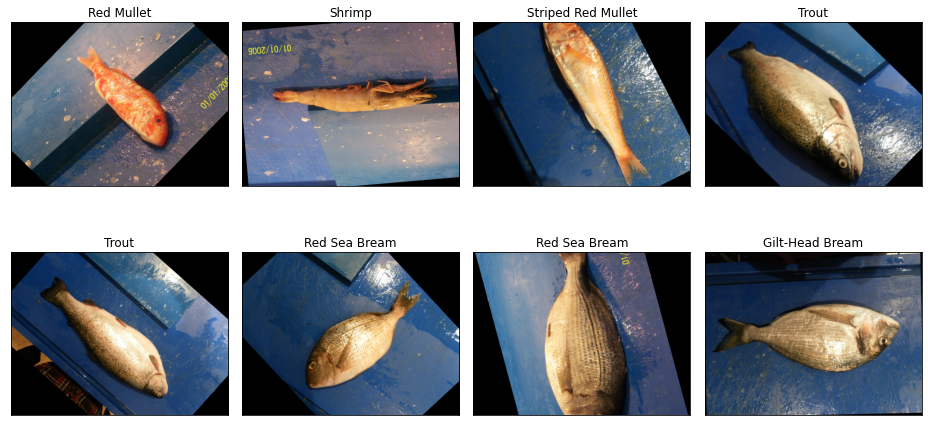

In [17]:
# Showing 8 Images 
import matplotlib.pyplot as plt

f,a = plt.subplots(nrows=2, ncols=4, figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(df.Images[i]))
    ax.set_title(df.Image_label[i])
    
plt.tight_layout()
plt.show()

In [19]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

input = (180,180)

img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

TRAIN_GENERATOR = img_datagen.flow_from_dataframe(
    dataframe = x_train,
    x_col = 'Images', 
    y_col ='Image_label',
    target_size = input, 
    batch_size = 180,
    color_mode='rgb', 
    class_mode = 'categorical', 
    shuffle = True)

VAL_GENERATOR = img_datagen.flow_from_dataframe(
    dataframe = x_val, 
    target_size=input, 
    x_col = 'Images', 
    y_col ='Image_label', 
    color_mode='rgb',
    class_mode='categorical',
    batch_size= 180, 
    shuffle=True)

TEST_GENERATOR = img_datagen.flow_from_dataframe(
    dataframe = x_test,
    target_size = input, 
    x_col = 'Images', 
    y_col ='Image_label',
    color_mode='rgb',
    class_mode = 'categorical',
    batch_size = 180, 
    shuffle = False)

Found 7200 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [21]:
TRAIN_GENERATOR.class_indices

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model, Sequential

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128,(3,3), padding='same', input_shape=(180, 180, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(128, activation= 'relu'),
        tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()





Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0

In [23]:
type(model)

tensorflow.python.keras.engine.sequential.Sequential

In [24]:

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard, EarlyStopping

# Load the TensorBoard notebook extension
%reload_ext tensorboard

import datetime
from time import time
log_dir = "logs/fit/"+ '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                   histogram_freq=1)
# Clear any logs from previous runs
!rm -rf ./logs/

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999) | (logs.get('loss') <= 0.01)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True
            
end_callback = myCallback()

checkpoints = ModelCheckpoint("model_weight.h5", 
                               monitor='val_accuracy', 
                               verbose=1, 
                               save_best_only=True, 
                               save_weights_only=False, 
                               mode='auto', 
                               save_freq='epoch')

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               min_delta=0, 
                               patience=10, 
                               verbose=1, 
                               mode='auto',
                               restore_best_weights=True,)

callbacks= [end_callback, tensorboard_callback, early_stopping, checkpoints]

start=time()

print("Model training time = "+str(time()-start))

Model training time = 8.702278137207031e-05


In [25]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss = 'categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [26]:
EPOCHS = 50

history = model.fit(TRAIN_GENERATOR,
                     epochs=EPOCHS,
                     steps_per_epoch=20,
                     callbacks=callbacks,
                     validation_data = VAL_GENERATOR,
                     validation_steps=5,
                     verbose = 1)


Epoch 1/50
20/20 [==============================] - 604s 30s/step - loss: 2.1932 - accuracy: 0.2178 - val_loss: 1.5588 - val_accuracy: 0.4611

Epoch 00001: val_accuracy improved from -inf to 0.46111, saving model to model_weight.h5
Epoch 2/50
20/20 [==============================] - 607s 30s/step - loss: 1.5507 - accuracy: 0.4744 - val_loss: 1.0941 - val_accuracy: 0.6400

Epoch 00002: val_accuracy improved from 0.46111 to 0.64000, saving model to model_weight.h5
Epoch 3/50
20/20 [==============================] - 632s 32s/step - loss: 1.0441 - accuracy: 0.6544 - val_loss: 0.6774 - val_accuracy: 0.7811

Epoch 00003: val_accuracy improved from 0.64000 to 0.78111, saving model to model_weight.h5
Epoch 4/50
20/20 [==============================] - 603s 30s/step - loss: 0.5938 - accuracy: 0.8044 - val_loss: 0.5340 - val_accuracy: 0.8389

Epoch 00004: val_accuracy improved from 0.78111 to 0.83889, saving model to model_weight.h5
Epoch 5/50
20/20 [==============================] - 603s 30s/st

In [27]:
model.save('IPAN_model.h5')

In [28]:
tf.keras.models.save_model(model, 'my_model.hdf5')

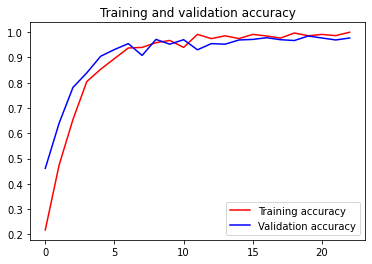

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

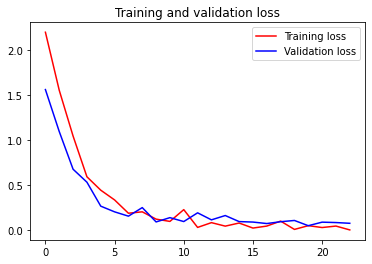

<Figure size 432x288 with 0 Axes>

In [30]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [49]:
test_steps_per_epoch = np.math.ceil(
    TEST_GENERATOR.samples / TEST_GENERATOR.batch_size)

predictions = model.predict(TEST_GENERATOR, steps=test_steps_per_epoch)
preds = np.argmax(predictions, axis=1)
preds

array([1, 0, 5, 4, 7, 7, 7, 0, 4, 8, 6, 5, 6, 6, 4, 8, 3, 3, 3, 8, 7, 7,
       8, 2, 5, 4, 0, 1, 6, 6, 2, 2, 0, 8, 6, 8, 7, 4, 0, 2, 6, 8, 0, 2,
       3, 0, 7, 8, 5, 2, 7, 7, 2, 5, 2, 5, 0, 5, 5, 2, 8, 8, 3, 3, 7, 1,
       2, 0, 6, 7, 2, 6, 6, 2, 4, 3, 3, 5, 3, 5, 1, 6, 1, 3, 7, 7, 6, 2,
       3, 7, 0, 3, 7, 0, 5, 3, 1, 8, 2, 5, 5, 5, 2, 6, 5, 1, 2, 1, 2, 3,
       7, 5, 8, 0, 3, 6, 1, 3, 1, 6, 7, 8, 4, 1, 8, 7, 4, 3, 6, 6, 8, 6,
       8, 0, 8, 0, 3, 5, 0, 1, 1, 2, 6, 5, 4, 6, 2, 3, 2, 5, 8, 4, 6, 3,
       1, 8, 3, 4, 0, 3, 2, 6, 3, 5, 1, 4, 3, 1, 4, 4, 0, 3, 8, 1, 4, 0,
       0, 8, 7, 2, 1, 2, 0, 6, 7, 1, 2, 3, 6, 2, 8, 4, 8, 3, 5, 6, 0, 3,
       3, 8, 2, 6, 2, 7, 2, 4, 0, 1, 0, 0, 8, 6, 2, 8, 0, 7, 2, 7, 4, 4,
       1, 5, 6, 7, 5, 8, 4, 7, 4, 8, 7, 4, 0, 5, 0, 3, 4, 8, 0, 4, 2, 2,
       5, 8, 8, 5, 3, 3, 8, 5, 6, 0, 0, 0, 1, 6, 1, 3, 3, 8, 5, 7, 5, 8,
       4, 8, 2, 3, 8, 1, 3, 0, 2, 4, 3, 1, 5, 0, 5, 6, 7, 5, 1, 5, 3, 5,
       2, 1, 1, 2, 4, 6, 8, 8, 2, 1, 7, 3, 2, 8, 8,

In [45]:
labels = TRAIN_GENERATOR.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [33]:
preds = [labels[k] for k in preds]
preds

['Gilt-Head Bream',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Sea Bream',
 'Striped Red Mullet',
 'Striped Red Mullet',
 'Striped Red Mullet',
 'Black Sea Sprat',
 'Red Sea Bream',
 'Trout',
 'Shrimp',
 'Sea Bass',
 'Shrimp',
 'Shrimp',
 'Red Sea Bream',
 'Trout',
 'Red Mullet',
 'Red Mullet',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Striped Red Mullet',
 'Trout',
 'Hourse Mackerel',
 'Sea Bass',
 'Red Sea Bream',
 'Black Sea Sprat',
 'Gilt-Head Bream',
 'Shrimp',
 'Shrimp',
 'Hourse Mackerel',
 'Hourse Mackerel',
 'Black Sea Sprat',
 'Trout',
 'Shrimp',
 'Trout',
 'Striped Red Mullet',
 'Red Sea Bream',
 'Black Sea Sprat',
 'Hourse Mackerel',
 'Shrimp',
 'Trout',
 'Black Sea Sprat',
 'Hourse Mackerel',
 'Red Mullet',
 'Black Sea Sprat',
 'Striped Red Mullet',
 'Trout',
 'Sea Bass',
 'Hourse Mackerel',
 'Striped Red Mullet',
 'Striped Red Mullet',
 'Hourse Mackerel',
 'Sea Bass',
 'Hourse Mackerel',
 'Sea Bass',
 'Black Sea Sprat',
 'Sea Bass',
 'Sea Bass',
 'Hourse Mackerel',
 '

In [34]:
#visualize test set
x_test.head()

,Images,Image_label
6143,/content/tmp/Fish_Dataset/Fish_Dataset/Gilt-He...,Gilt-Head Bream
3571,/content/tmp/Fish_Dataset/Fish_Dataset/Black S...,Black Sea Sprat
3940,/content/tmp/Fish_Dataset/Fish_Dataset/Sea Bas...,Sea Bass
2562,/content/tmp/Fish_Dataset/Fish_Dataset/Red Sea...,Red Sea Bream
1953,/content/tmp/Fish_Dataset/Fish_Dataset/Striped...,Striped Red Mullet


                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      0.98      0.99       116
   Gilt-Head Bream       0.96      0.97      0.97       109
   Hourse Mackerel       0.96      0.99      0.97        96
        Red Mullet       1.00      1.00      1.00        91
     Red Sea Bream       0.99      0.98      0.98        93
          Sea Bass       0.90      0.96      0.93        98
            Shrimp       1.00      0.97      0.98       116
Striped Red Mullet       1.00      0.94      0.97        85
             Trout       0.97      0.98      0.97        96

          accuracy                           0.97       900
         macro avg       0.98      0.97      0.97       900
      weighted avg       0.98      0.97      0.97       900



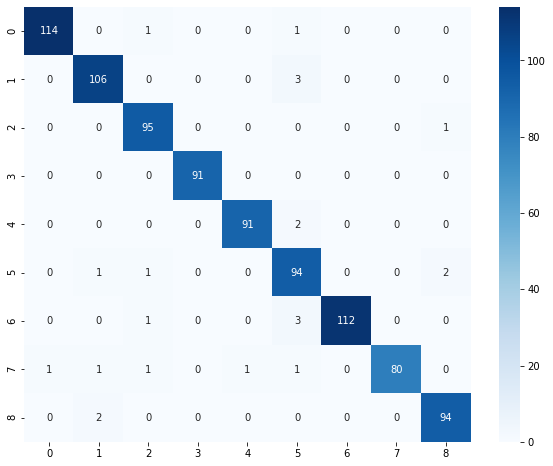

In [54]:
import seaborn as sns
from sklearn import metrics

true_classes = TEST_GENERATOR.classes
class_labels = list(TRAIN_GENERATOR.class_indices.keys()) 

report = metrics.classification_report(true_classes, 
                                       preds, 
                                       target_names = class_labels)
print(report)  

corr_pred = metrics.confusion_matrix(true_classes, preds)
fig=plt.figure(figsize=(10, 8))
sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

In [85]:
!pip install --upgrade pip

     |████████████████████████████████| 1.6MB 4.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [86]:
!pip install tensorflowjs

     |████████████████████████████████| 64 kB 1.6 MB/s 


In [96]:
import tensorflowjs as tfjs

!tensorflowjs_converter --input_format=keras \
                       content/my_model.hDF5 \
                       content/IPAN_model.json

2021-06-08 10:49:52.695569: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/converter.py", line 813, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/converter.py", line 817, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/converter.py", line 804, in convert
    weight_shard_size_bytes, metadata_map)
  File "/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/converter.py", line 501, in _dispatch_converter
    metadata=metadata_map)
  File "/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/converter.py", line 76, in dispatch_keras_h5_to_tfjs_layers_model_conversion
   